In [1]:
#!pip install tensorflow-metal
#!pip install tensorflow-macos

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
import keras.layers
from keras import layers,models
from keras.layers import Dense, Dropout
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
import keras

In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [6]:
pretrained_model = keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

2024-09-09 12:39:23.087914: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-09-09 12:39:23.087934: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-09-09 12:39:23.087939: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-09-09 12:39:23.087955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-09 12:39:23.087967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
image_size = (224, 224)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "./SoybeanLeafDiseaseImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6410 files belonging to 3 classes.
Using 5128 files for training.
Using 1282 files for validation.


In [15]:
checkpoint_path = "soybean_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
])


inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        #steps_per_epoch=100,
        validation_data=val_ds,
        #validation_steps=50,
        epochs=100,
        callbacks=[
            early_stopping,
            create_tensorboard_callback("training_logs", 
                                        "soybean_classification"),
            checkpoint_callback,
        ],
        verbose=1
    )

Saving TensorBoard log files to: training_logs/soybean_classification/20240909-124132
Epoch 1/100


2024-09-09 12:41:33.440000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 433ms/step - accuracy: 0.3606 - loss: 1.3306 - val_accuracy: 0.5788 - val_loss: 0.9846
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - accuracy: 0.4978 - loss: 1.0978 - val_accuracy: 0.6669 - val_loss: 0.8810
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.5895 - loss: 0.9873 - val_accuracy: 0.6942 - val_loss: 0.8218
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - accuracy: 0.6330 - loss: 0.9229 - val_accuracy: 0.7059 - val_loss: 0.7806
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.6429 - loss: 0.8970 - val_accuracy: 0.7114 - val_loss: 0.7506
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.6544 - loss: 0.8624 - val_accuracy: 0.7168 - val_loss: 0.7248
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.6744 - loss: 0.8370 - val_accuracy: 0.7223 - val_loss: 0.7044
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.6883 - loss: 0.8027 - val_accuracy

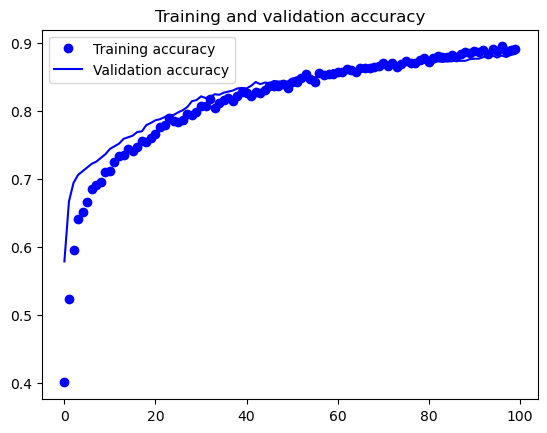

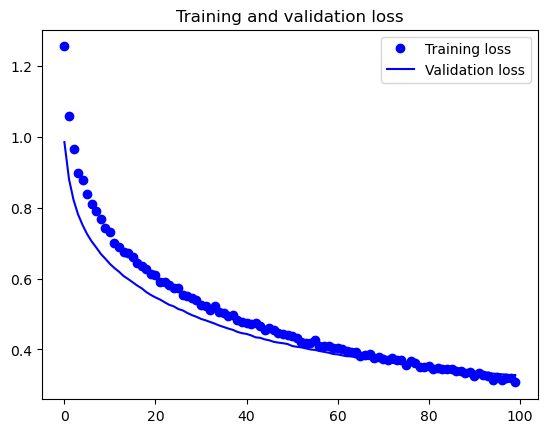

In [20]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
model.save("./models/leaf.soybean.mobilenetv3large.keras")
reconstructed_model = keras.models.load_model("./models/leaf.soybean.mobilenetv3large.keras")